In [49]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import time
import json
import collections
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [4]:
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#     annotation_zip = tf.keras.utils.get_file('captions.zip',\
#                                            cache_subdir=os.path.abspath('.'),\
#                                            origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',\
#                                            extract=True)
#     annotation_file = os.path.dirname(annotation_zip) + 'annotations/captions_train2014.json'
#     os.remove(annotation_zip)

# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#     image_zip = tf.keras.utils.get_file('train2014.zip',\
#                                        cache_subdir=os.path.abspath('.'),\
#                                        origin='http://images.cocodataset.org/zips/train2014.zip',\
#                                        extract=True)
#     PATH = os.path.dirname(image_zip) + image_folder
#     os.remove(image_zip)
# else:
#     PATH = os.path.abspath('.') + image_folder

annotation_folder = '/annotations/'
dest_path = '/usb/datasets/coco2014/'
if not os.path.exists(dest_path + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',\
                                           cache_subdir=dest_path,\
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',\
                                           extract=True)
    annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'
    print(annotation_zip)
    os.remove(annotation_zip)

image_folder = '/train2014/'
if not os.path.exists(dest_path + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',\
                                       cache_subdir=dest_path,\
                                       origin='http://images.cocodataset.org/zips/train2014.zip',\
                                       extract=True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = dest_path + image_folder
print(image_zip)

252887040/252872794 [==============================] - 18s 0us/step
/usb/datasets/coco2014/captions.zip
13510582272/13510573713 [==============================] - 638s 0us/step
/usb/datasets/coco2014/train2014.zip


## get a subset of the captions

In [8]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
    

In [13]:
PATH

'/usb/datasets/coco2014/train2014/'

In [16]:
## grouping all captions of each image together
img_path_to_captions = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + "COCO_train2014_" + '%012d.jpg'%(val['image_id'])
    img_path_to_captions[image_path].append(caption)
    

In [22]:
image_paths = list(img_path_to_captions.keys())
random.shuffle(image_paths)

train_img_paths = image_paths[:6000]
print(len(train_img_paths))

6000


In [23]:
train_captions = []
img_name_vectors = []

for image_path in train_img_paths:
    captions = img_path_to_captions[image_path]
    train_captions.extend(captions)
    img_name_vectors.extend([image_path] * len(captions))

In [26]:
print(len(train_captions))
print(len(img_name_vectors))

30006
30006


<start> a picture of a room at a bed and breakfast <end>


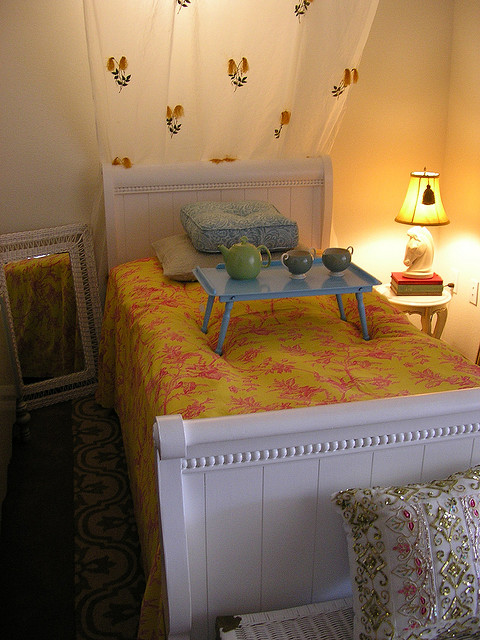

In [29]:
print(train_captions[0])
#print(img_name_vectors[0])
Image.open(img_name_vectors[0])

In [41]:
# using inceptionv3 pretrained on imagenet
# requires 299 by 299 images in the range of -1 to 1

# img = tf.io.decode_jpeg(tf.io.read_file(img_name_vectors[0]), channels=3)
# img = tf.image.resize(img, (299, 299))
# img = tf.keras.applications.inception_v3.preprocess_input(img)

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, img_path

## model

In [42]:
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = model.input
last_hidden_layer = model.layers[-1].output

extract_features_model = tf.keras.Model(new_input, last_hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


## image data cache

In [57]:
encode_train = sorted(set(img_name_vectors))
dataset = tf.data.Dataset.from_tensor_slices(encode_train)
dataset = dataset.map(load_image).batch(16) #, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(dataset):
    batch_features = model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode('utf-8')
        np.save(path_of_feature, bf.numpy)

100%|██████████| 375/375 [02:38<00:00,  2.36it/s]


## caption data

In [66]:
## only choosing the top 5000 words fro the vocabulary
top_k = 5000
def max_len(tensor):
    return max(len(t) for t in tensor)

In [68]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token='<unk>')
tokenizer.fit_on_texts(train_captions)


In [71]:
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 'end': 3,
 'start': 4,
 'on': 5,
 'of': 6,
 'the': 7,
 'in': 8,
 'with': 9,
 'and': 10,
 'is': 11,
 'man': 12,
 'to': 13,
 'sitting': 14,
 'an': 15,
 'two': 16,
 'people': 17,
 'at': 18,
 'are': 19,
 'standing': 20,
 'white': 21,
 'next': 22,
 'woman': 23,
 'table': 24,
 'street': 25,
 'holding': 26,
 'that': 27,
 'some': 28,
 'person': 29,
 'large': 30,
 'it': 31,
 'group': 32,
 'down': 33,
 'top': 34,
 'up': 35,
 'field': 36,
 'small': 37,
 'black': 38,
 'near': 39,
 'his': 40,
 'tennis': 41,
 'young': 42,
 'dog': 43,
 'front': 44,
 'plate': 45,
 'train': 46,
 'riding': 47,
 'room': 48,
 'red': 49,
 'by': 50,
 'baseball': 51,
 'cat': 52,
 'water': 53,
 'while': 54,
 'has': 55,
 'bathroom': 56,
 'pizza': 57,
 'sign': 58,
 'food': 59,
 'walking': 60,
 'playing': 61,
 'blue': 62,
 'grass': 63,
 'kitchen': 64,
 'snow': 65,
 'there': 66,
 'parked': 67,
 'men': 68,
 'boy': 69,
 'couple': 70,
 'green': 71,
 'bed': 72,
 'bus': 73,
 'three': 74,
 'building': 75,
 'side'

In [72]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: 'end',
 4: 'start',
 5: 'on',
 6: 'of',
 7: 'the',
 8: 'in',
 9: 'with',
 10: 'and',
 11: 'is',
 12: 'man',
 13: 'to',
 14: 'sitting',
 15: 'an',
 16: 'two',
 17: 'people',
 18: 'at',
 19: 'are',
 20: 'standing',
 21: 'white',
 22: 'next',
 23: 'woman',
 24: 'table',
 25: 'street',
 26: 'holding',
 27: 'that',
 28: 'some',
 29: 'person',
 30: 'large',
 31: 'it',
 32: 'group',
 33: 'down',
 34: 'top',
 35: 'up',
 36: 'field',
 37: 'small',
 38: 'black',
 39: 'near',
 40: 'his',
 41: 'tennis',
 42: 'young',
 43: 'dog',
 44: 'front',
 45: 'plate',
 46: 'train',
 47: 'riding',
 48: 'room',
 49: 'red',
 50: 'by',
 51: 'baseball',
 52: 'cat',
 53: 'water',
 54: 'while',
 55: 'has',
 56: 'bathroom',
 57: 'pizza',
 58: 'sign',
 59: 'food',
 60: 'walking',
 61: 'playing',
 62: 'blue',
 63: 'grass',
 64: 'kitchen',
 65: 'snow',
 66: 'there',
 67: 'parked',
 68: 'men',
 69: 'boy',
 70: 'couple',
 71: 'green',
 72: 'bed',
 73: 'bus',
 74: 'three',
 75: 'building',
 76: 's

In [73]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [75]:
train_sequence = tokenizer.texts_to_sequences(train_captions)

In [76]:
train_sequence

[[4, 2, 103, 6, 2, 48, 18, 2, 72, 10, 659, 3],
 [4, 2, 72, 9, 2, 1333, 313, 5, 31, 27, 11, 14, 5, 2, 24, 3],
 [4, 2, 358, 9, 28, 132, 1333, 4643, 14, 5, 2, 132, 72, 3],
 [4, 2, 437, 14, 5, 34, 6, 2, 21, 72, 3],
 [4, 2, 358, 9, 2, 3565, 10, 16, 770, 5, 31, 14, 5, 2, 72, 3],
 [4, 2, 30, 329, 14, 5, 34, 6, 15, 349, 351, 3],
 [4, 2, 21, 10, 49, 177, 5, 351, 9, 2976, 148, 8, 7, 166, 3],
 [4, 15, 164, 18, 15, 349, 9, 2, 148, 10, 351, 3],
 [4, 15, 164, 331, 13, 645, 214, 5, 7, 351, 3],
 [4, 2, 30, 430, 329, 5, 7, 351, 6, 15, 349, 3],
 [4, 2, 100, 10, 21, 46, 1836, 139, 2, 46, 224, 9, 17, 347, 3],
 [4, 4644, 839, 2, 46, 18, 15, 431, 224, 3],
 [4, 2, 525, 2119, 6, 2, 46, 11, 729, 35, 13, 7, 1837, 3],
 [4, 17, 19, 60, 5, 7, 508, 6, 15, 973, 46, 3],
 [4, 2, 100, 2309, 46, 67, 5, 2, 46, 272, 22, 13, 2, 1630, 508, 3],
 [4, 2, 52, 14, 10, 688, 18, 2, 314, 313, 3],
 [4, 2, 52, 14, 8, 44, 6, 2, 293, 262, 3],
 [4, 2, 52, 262, 7, 486, 6, 2, 293, 54, 14, 5, 7, 183, 3],
 [4, 2, 52, 11, 14, 5, 7, 183, 688,

In [87]:
caption_vector_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequence, padding='post')

In [88]:
caption_vector_padded

array([[   4,    2,  103, ...,    0,    0,    0],
       [   4,    2,   72, ...,    0,    0,    0],
       [   4,    2,  358, ...,    0,    0,    0],
       ...,
       [   4,   16,  439, ...,    0,    0,    0],
       [   4,   16,  415, ...,    0,    0,    0],
       [   4,   16, 1322, ...,    0,    0,    0]], dtype=int32)

In [89]:
len(train_captions)

30006

In [90]:
maxLen = max_len(train_sequence)

In [91]:
maxLen

48

In [92]:
caption_vector_padded.shape

(30006, 48)

## split data

In [96]:
from sklearn.model_selection import train_test_split

In [98]:
print(type(caption_vector_padded))
print(caption_vector_padded.shape)
print(type(img_name_vectors))
print(len(img_name_vectors))

<class 'numpy.ndarray'>
(30006, 48)
<class 'list'>
30006


In [114]:
#img_name_vectors is a list, caption_vector_padded is ndarray
# so both are lists
caption_vectors = [i for i in caption_vector_padded]

In [115]:

X_train, X_test, y_train, y_test = train_test_split(img_name_vectors, caption_vectors, test_size=0.2)

In [117]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(X_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64
    


In [118]:
X_train[0]

'/usb/datasets/coco2014/train2014/COCO_train2014_000000022451.jpg'

In [119]:
def map_func(img_name, cap):
    img = np.load(img_name + '.npy')
    return img, cap

In [122]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## model

In [2]:
X_train[0]

NameError: name 'X_train' is not defined